In [1]:
#local libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


#spark libraries

from pyspark import SparkConf
from pyspark.sql import SparkSession
import databricks.koalas as ks

In [2]:
conf = SparkConf().setAll([("spark.driver.memory", "2g"), ("spark.master", "local"), ("spark.executor.memory", "2g"), ("spark.memory.fraction", "0.6")])

spark = SparkSession.builder.config(conf = conf).getOrCreate()

In [3]:
spark

In [4]:
df = ks.read_csv("/Users/ramonsotogarcia/Desktop/Data/autompg.csv", header = 0)

df.spark.cache()

df.count()

_c0             398
mpg             398
cylinders       398
displacement    398
horsepower      389
weight          395
acceleration    398
modelyear       398
origin          398
carname         398
dtype: int64

In [5]:
df.isna().sum(axis=0)/ df.shape[0]

_c0             0.000000
mpg             0.000000
cylinders       0.000000
displacement    0.000000
horsepower      0.022613
weight          0.007538
acceleration    0.000000
modelyear       0.000000
origin          0.000000
carname         0.000000
dtype: float64

In [6]:
df.head(5)

,_c0,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,carname
0,0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""""""chevrolet chevelle malibu"""""""
1,1,15.0,8,350.0,165.0,NaN,11.5,70,1,"""""""buick skylark 320"""""""
2,2,18.0,8,318.0,NaN,3436.0,11.0,70,1,"""""""plymouth satellite"""""""
3,3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""""""amc rebel sst"""""""
4,4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""""""ford torino"""""""


In [41]:
df.dtypes

mpg             float64
cylinders         int32
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
modelyear         int32
origin            int32
brand            object
dtype: object

### Feature engineering

In [9]:
#define functions and create new features

def remove_special(carname):
    return carname[3:-3]

def select_brand(carname):
    return carname[3:-3].split(" ")[0]   #this removes the special characters and selects the car brand
    

df["brand"] = df["carname"].apply(lambda x: select_brand(x))
df["carname"] = df["carname"].apply(lambda x: remove_special(x))

#this function returns the car brand

/opt/anaconda3/envs/koalas-dev-env/lib/python3.8/site-packages/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [10]:
#remove unwanted columns

df  = df.drop(columns = ["_c0"])


In [11]:
df.head(5)  #check new features have been created

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,carname,brand
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,NaN,11.5,70,1,buick skylark 320,buick
2,18.0,8,318.0,NaN,3436.0,11.0,70,1,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,ford


In [12]:
df.groupby("brand").count().sort_values(by = "mpg", ascending = False)["mpg"]

brand
ford             51
chevrolet        43
plymouth         31
amc              28
dodge            28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
peugeot           8
fiat              8
audi              7
vw                6
chrysler          6
volvo             6
renault           5
saab              4
opel              4
subaru            4
chevy             3
bmw               2
cadillac          2
maxda             2
mercedes-benz     2
mercedes          1
vokswagen         1
toyouta           1
capri             1
hi                1
nissan            1
triumph           1
chevroelt         1
Name: mpg, dtype: int64

In [13]:
#notice there are some coding errors

df.loc[df["brand"] == "chevroelt", ["brand"]] = "chevrolet"
df.loc[(df["brand"] == "vw") | (df["brand"] == "vokswagen"), ["brand"]] = "volkswagen"
df.loc[df["brand"] == "mercedes", ["brand"]] = "mercedes-benz"
df.loc[df["brand"] == "toyouta", ["brand"]] = "toyota"
df.loc[df["brand"] == "maxda", ["brand"]] = "mazda"

#other

df.loc[df["modelyear"] == 1, ["modelyear"]] = 71


In [14]:
df.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin,carname,brand
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,NaN,11.5,70,1,buick skylark 320,buick
2,18.0,8,318.0,NaN,3436.0,11.0,70,1,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,ford


In [15]:
df.groupby("modelyear").count().sort_values(by = "mpg", ascending = False)["mpg"]

modelyear
73    40
78    36
76    34
82    31
75    30
81    29
80    29
70    29
79    29
72    28
77    28
71    28
74    27
Name: mpg, dtype: int64

### Remove NA values

In [16]:
df.dropna(inplace = True)

df.isna().sum(axis=0) / df.shape[0]

mpg             0.0
cylinders       0.0
displacement    0.0
horsepower      0.0
weight          0.0
acceleration    0.0
modelyear       0.0
origin          0.0
carname         0.0
brand           0.0
dtype: float64

In [17]:
df.groupby("cylinders").count().sort_values(by = "mpg", ascending = False)["mpg"]

cylinders
4    197
8     99
6     83
3      4
5      3
Name: mpg, dtype: int64

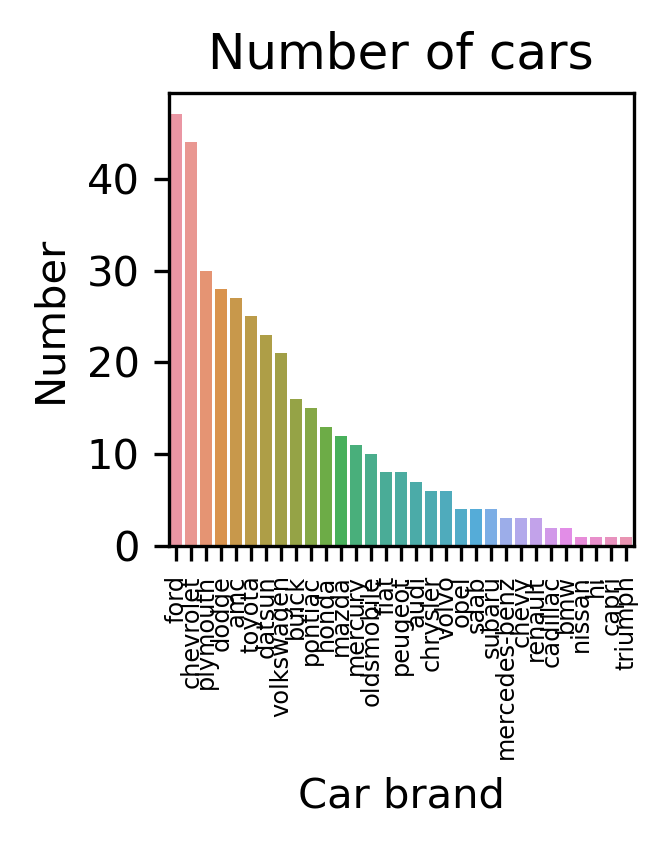

In [18]:
pdf = df.to_pandas()  #bring data back to head node

brands = [brand for brand,df in pdf.groupby("brand")]

number_cars = pdf.groupby("brand").count()["mpg"].values

df_plot = pd.DataFrame(data = {"Car brand": brands, "Number": number_cars}).sort_values(by = "Number", ascending = False)

plt.figure(figsize = (2,2), dpi = 300)

sns.barplot(data = df_plot, x = "Car brand", y = "Number")
plt.xticks(rotation = 90, fontsize = "xx-small")
plt.title("Number of cars")
plt.show()

In [19]:
df.groupby("cylinders").count().sort_values(by = "mpg", ascending = False)["mpg"]

cylinders
4    197
8     99
6     83
3      4
5      3
Name: mpg, dtype: int64

### Aggregated statistics

In [20]:
df.groupby("modelyear").mean().sort_values(by = "horsepower", ascending = False)["horsepower"]

modelyear
70    147.111111
73    130.307692
72    121.814815
77    105.071429
71    104.423077
79    101.206897
76    101.117647
75    101.066667
78     99.694444
74     95.920000
82     81.466667
81     81.035714
80     77.481481
Name: horsepower, dtype: float64

It seems there is a drop in the average horsepower in cars made over the 70s and into the early 80s. To confirm this let us see in a plot whether we can capture this trend:

In [21]:
new = df.groupby("modelyear").mean().sort_values(by = "horsepower", ascending = False)  #perform aggregation and save as df

modelyear = new.index.to_numpy()  #extract model year from aggregated results
horsepower = new["horsepower"].to_numpy()

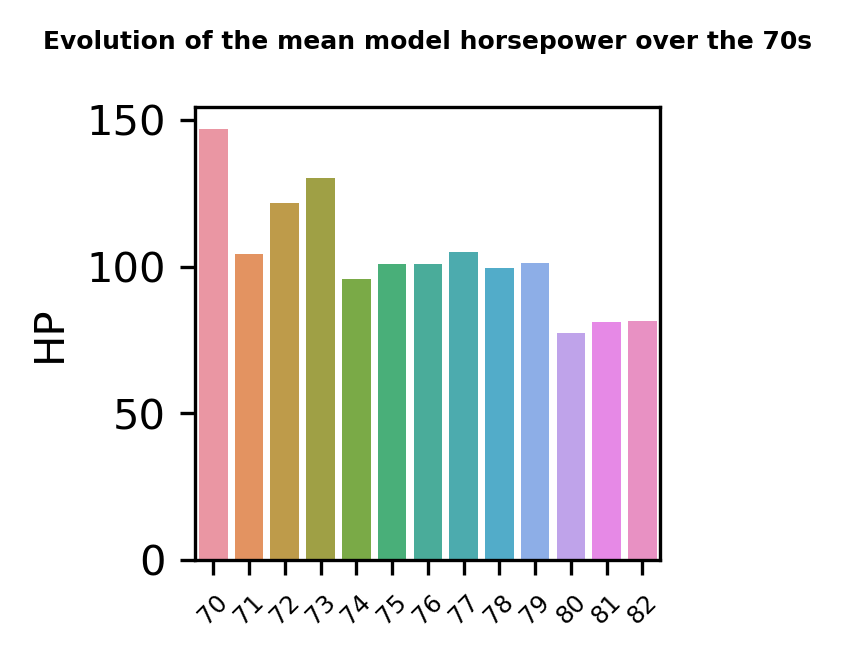

In [22]:
#let us visualise the results of the aggregation

results_df = pd.DataFrame(data = {"Model year": modelyear, "HP": horsepower})

plt.figure(figsize = (2,2), dpi = 300)

sns.barplot(data = results_df, x = "Model year", y = "HP")
plt.xticks(rotation = 45, fontsize = "xx-small")
plt.title("Evolution of the mean model horsepower over the 70s", fontweight = "bold", fontsize = 6, pad = 14)
plt.xlabel("")
plt.show()


There was a change in customer behaviour from the 70s to the 80s. Cars with more autonomy and less horsepower began to be demanded by customers, with brands like Volkswagen and Honda being able to respond to those demands. Brands such as Cadillac and Chrysler, however, used to produce cars targeted at a small segment of customers that demanded more horsepower at the expense of less autonomy.

### Machine learning with Pyspark ML

#### Bring the data to PySpark df

In [23]:
df = df.drop(columns = "carname")

sdf = df.to_spark()

sdf.cache()

sdf.count()

386

### Train/validation set approach

In [24]:
splits = sdf.randomSplit([0.8, 0.2], seed = 42)

train_df = splits[0].cache()
test_df = splits[1].cache()

In [25]:
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor



In [46]:
#build pipeline

car_indexer = StringIndexer(inputCol = "brand", outputCol = "brand_indexer", handleInvalid='keep')

cyl_indexer = StringIndexer(inputCol = "cylinders", outputCol = "cyl_indexer", handleInvalid='keep')

vec_assembler = VectorAssembler(inputCols=["mpg", "cyl_indexer", "brand_indexer", "weight"], outputCol="featuresCol", handleInvalid='error')

rf = RandomForestRegressor(featuresCol='featuresCol', labelCol = "horsepower", numTrees = 50, minInstancesPerNode = 5)

pipeline = Pipeline(stages = [car_indexer, cyl_indexer, vec_assembler, rf])

#train model

model = pipeline.fit(train_df)


#get predictions

pred_df = model.transform(test_df)



#### Evaluate model on test data

In [58]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="horsepower", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(pred_df)

print(round(rmse, 2))

18.44


### Cross-validation

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#we build the parameter grid

param_grid = ParamGridBuilder().addGrid(rf.numTrees, [100,200]).addGrid(rf.minInstancesPerNode, [5,6,7]).build()

#grid search cv in PySpark ML

grid_cv = CrossValidator(estimator = pipeline, estimatorParamMaps=param_grid, numFolds = 3, evaluator = evaluator, seed = 42)

#train model

grid_model = grid_cv.fit(train_df)


In [54]:
grid_model.avgMetrics  #el promedio de la metrica en 3 folds para cada combinacion de hiperparametros

[15.014437116180797,
 15.05961804408571,
 15.038555279939953,
 15.110138417341158,
 15.038695789511642,
 15.058725101673572]

In [78]:
rf = grid_model.bestModel.stages[3]   #extraemos el mejor modelo

rf.getOrDefault('maxDepth')   #con esta funcion podemos extraer los parametros que deseamos

5

#### Evaluate best model on test data

In [82]:
prediction_df = grid_model.transform(test_df)

rmse = RegressionEvaluator(
    labelCol="horsepower", predictionCol="prediction", metricName="rmse").evaluate(prediction_df)

print(round(rmse,2))

18.06
